In [2]:
# 지금까지 분류 모형 종류에 대해 공부했다
# 이러한 모형들을 실제로 이용할 때 최종적으로 해야하는 단계에서 고려해야 하는 사항들에 대해 공부해보겠다

In [8]:
# 12.01 모형 최적화
    # 하이퍼 파라미터 튜닝이라고 부른다
    # 모형을 하나 선택해서 하든가 여러 모형을 비교하든간에 최종적으로는 그 안에 들어가는 파라미터를 조절해줘야 한다
# 12.02 비대칭 데이터 문제
    # 분류 모형 문제에서 클래스의 개수가 많고 적어서 서로 다른 경우가 있다(희귀병과 정상인). 그러면 나중에 문제가 발생한다. 어떤 문제? 어떻게 해결?
# 12.03 특징 선택
# 12.04 대규모 데이터 학습
    # 데이터가 너무 큰 경우
        # 데이터의 종류(D)가 너무 많은 경우, 데이터의 개수(N)가 너무 많은 경우 두 가지

# 12.01 모형 최적화

머신 러닝 모형이 완성된 후에는 최적화 과정을 통해 예측 성능을 향상시킨다.

In [9]:
# 하이퍼 파라미터 튜닝

## Scikit-Learn 의 모형 하이퍼 파라미터 튜닝 도구

Scikit-Learn에서는 다음과 같은 모형 최적화 도구를 지원한다.

* [`validation_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
  * 단일 하이퍼 파라미터 최적화
* [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  * 그리드를 사용한 복수 하이퍼 파라미터 최적화
* [`ParameterGrid`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html)  
 * 복수 파라미터 최적화용 그리드


In [12]:
# 밸리데이션 커브: 우리가 튜닝해야할 하이퍼 파라미터가 딱 하나밖에 없을 떄
# 그리드서치CV: 하이퍼 파라미터가 두 개 이상 일 때. 자기가 알아서 어떤 파라미터가 좋은지 가려낸다
# 파라미터그리드: 수동으로 그리드 서치하는 것

## `validation_curve` 

`validation_curve` 함수는 최적화할 파라미터 이름과 범위, 그리고 성능 기준을 `param_name`, `param_range`, `scoring` 인수로 받아 파라미터 범위의 모든 경우에 대해 성능 기준을 계산한다.

In [1]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 10)

In [2]:
%%time
train_scores, test_scores = \
    validation_curve(SVC(), X, y,
                     param_name="gamma", param_range=param_range,
                     cv=10, scoring="accuracy", n_jobs=1)

CPU times: user 50.7 s, sys: 0 ns, total: 50.7 s
Wall time: 50.7 s


In [21]:
# 각각의 하이퍼 파라미터 값의 k-fold crossvalidation 한 값이 나온다
# 트레인스코어, 테스트 스코어 각각 100개씩

In [19]:
# SVC 함수에서 커널이 선택돼 있지 않으므로 디폴트 값인 RBF, 가우시안 커널 선택
# 감마 값에 따라서 원이 둥그스름하게 만들어질 수도, 뾰족뾰족하게 만들어질 수도 있다.
# 여기서는 이러한 감마 값을 조정해야할 하이퍼파라미터 값으로 정했다
# 파라미터 레인지는 보통 logspace 많이 쓴다. 로그 스케일로 죽 훑어 보는 게 훨씬 효율적으로 스캐닝을 할 수 있다
    # ..., 0.001, 0.01, 0.1, 1, 10, 100, ...
    # np.logspace(-6, -1, 10)은 백만분의 일부터 10분의 1까지를 10개의 점으로 나누는 것. 10종류의 파라미터를 테스트해보는 것
# cv는 k-fold 교차검증을 하게 된다. 10개짜리의 k-fold로 나눠서 10번 테스트해본다는 것
    # 10종류의 파라미터를 테스트할 때 한 포인트에서 교차검증을 10번하는 것. 모델링 100번하는 것.
# n_jobs는 나중에 설명

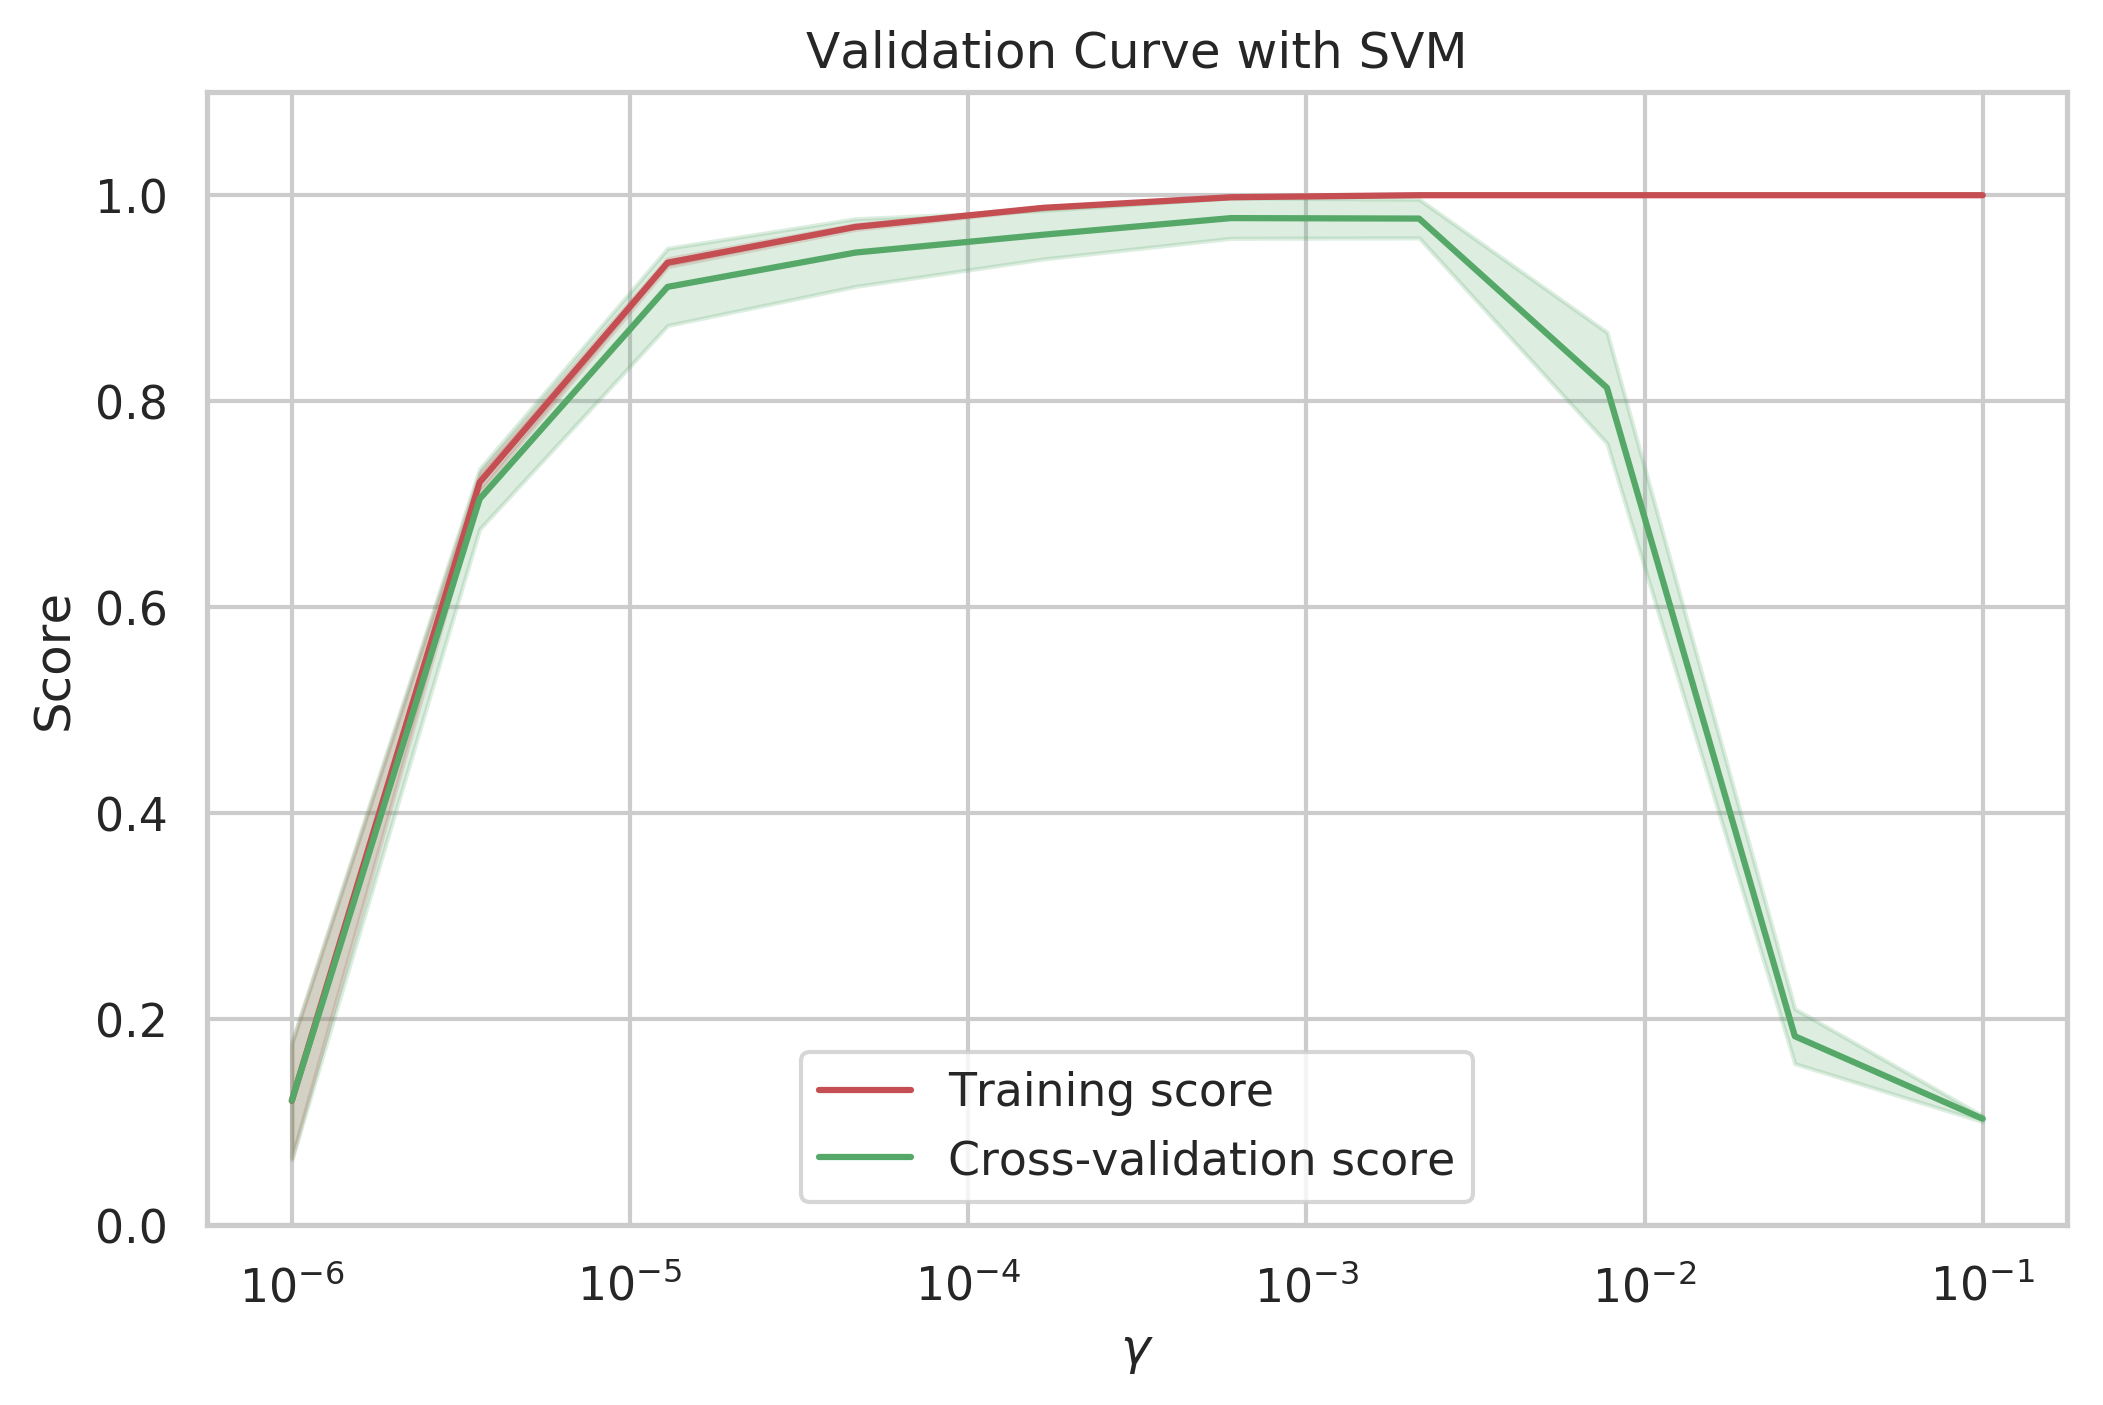

In [3]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

In [25]:
# 감마 값이 점점 커질수록 과최적화. 
# 트레인 스코어와 달리 테스트 스코어는 상승하다 떨어진다.
# 우리는 1000분의 1과 100분의 1 사이의 값을 선택하면 된다
# 이후 이 사이 구간을 또다시 모형 최적화 해 더 정확한 값을 구하면 됨

## `GridSearchCV` 

In [26]:
# 그리드서치는 밸리데이션 커브와 달리 다차원으로 모형 최적화 해준다

`GridSearchCV`  클래스는 `validation_curve` 함수와 달리 모형 래퍼(Wrapper) 성격의 클래스이다.  클래스 객체에 `fit` 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다. 생성된 복수개와 내부 모형과 실행 결과는 다음 속성에 저장된다.

* `grid_scores_ `
 * param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
  * parameters: 사용된 파라미터
  * mean_validation_score: 교차 검증(cross-validation) 결과의 평균값
  * cv_validation_scores: 모든 교차 검증(cross-validation) 결과
* `best_score_` 
 * 최고 점수 
* `best_params_`
 * 최고 점수를 낸 파라미터
* `best_estimator_`
 * 최고 점수를 낸 파라미터를 가진 모형

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10, n_jobs=1)
%time gs = gs.fit(X, y)

CPU times: user 6min 26s, sys: 600 ms, total: 6min 27s
Wall time: 6min 27s


/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
# 파이프라인, scaler와 classifier
# 하이퍼 파라미터 조정
    # SVC에서는 커널을 바꿀 수 있다. linear, RBF
    # RBF에서는 감마값 바꿀 수 있고, linear 커널에서는 대문자 C 값 바꿀 수 있다. C는 슬랙변수 조절하는 가중치였다
# clf다음에 _ 두 개 들어간다. clf__C
    # linear의 경우 8포인트, RBF의 경우에 8*8 = 64포인트의 파라미터 값을 테스트 해보는 것
    # 각각의 포인트에서 교차검증을 10번 토탈 720번 피팅하는 게 된다

In [5]:
gs.cv_results_["params"]

[{'clf__C': 0.0001, 'clf__kernel': 'linear'},
 {'clf__C': 0.001, 'clf__kernel': 'linear'},
 {'clf__C': 0.01, 'clf__kernel': 'linear'},
 {'clf__C': 0.1, 'clf__kernel': 'linear'},
 {'clf__C': 1.0, 'clf__kernel': 'linear'},
 {'clf__C': 10.0, 'clf__kernel': 'linear'},
 {'clf__C': 100.0, 'clf__kernel': 'linear'},
 {'clf__C': 1000.0, 'clf__kernel': 'linear'},
 {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 100.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1000.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C

In [ ]:
# 어떤 파라미터들을 테스트했는지 쭉 나온다. 72개의 조합이 나온다

In [6]:
gs.cv_results_["mean_test_score"]

array([0.20868114, 0.91819699, 0.95269894, 0.95826377, 0.95826377,
       0.95826377, 0.95826377, 0.95826377, 0.11908737, 0.12020033,
       0.1213133 , 0.10350584, 0.10127991, 0.11185309, 0.10183639,
       0.10127991, 0.11908737, 0.12020033, 0.1213133 , 0.10350584,
       0.10127991, 0.11185309, 0.10183639, 0.10127991, 0.11908737,
       0.12020033, 0.13967724, 0.10350584, 0.10127991, 0.11185309,
       0.10183639, 0.10127991, 0.11908737, 0.68614357, 0.91207568,
       0.40567613, 0.10127991, 0.11185309, 0.10183639, 0.10127991,
       0.70339455, 0.93266555, 0.9638286 , 0.90984975, 0.11908737,
       0.10127991, 0.10127991, 0.10127991, 0.934335  , 0.95659432,
       0.97161937, 0.9115192 , 0.12966055, 0.10127991, 0.10127991,
       0.10127991, 0.95548136, 0.96160267, 0.97161937, 0.9115192 ,
       0.12966055, 0.10127991, 0.10127991, 0.10127991, 0.95993322,
       0.96215915, 0.97161937, 0.9115192 , 0.12966055, 0.10127991,
       0.10127991, 0.10127991])

In [28]:
# 72개의 조합에 대한 테스트 성능

In [7]:
print(gs.best_score_)
print(gs.best_params_)

0.9716193656093489
{'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [31]:
# 가장 좋은 테스트 성능의 정확도
# 이러한 결과가 나온 다음 이 근처에서 다시 미세 그리드를 만들어 테스트를 해보면 된다

## `ParameterGrid` 

In [43]:
# 파라미터의 조합을 만드는 명령어
# 위의 72포인트 같이
# 이를 적절히 나눠서 수동으로 분산처리를 해주면 된다는 것

때로는 scikit-learn 이 제공하는 GridSearchCV 이외의 방법으로 그리드 탐색을 해야하는 경우도 있다. 이 경우 파라미터를 조합하여 탐색 그리드를 생성해 주는 명령어가 `ParameterGrid` 이다. `ParameterGrid` 는 탐색을 위한 iterator 역할을 한다.

In [8]:
from sklearn.model_selection import ParameterGrid

In [9]:
param_grid = {'a': [1, 2], 'b': [True, False]}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [10]:
param_grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
list(ParameterGrid(param_grid))

[{'kernel': 'linear'},
 {'gamma': 1, 'kernel': 'rbf'},
 {'gamma': 10, 'kernel': 'rbf'}]

In [35]:
# 72개, k-fold까지 합치면 720개를 해야 하는데 순서대로 해야 하나?
# 그건 아니다. 그게 다 독립적으로 해도 되는 것.
# 내가 능력만 있다면 병렬적으로, 720개를 갖다가 동시에 돌려도 되는 것
# 그 명령어가 n_jobs
# 우리 컴퓨터의 CPU에는 코어라고 하는 모듈이 있다. 코어는 실제로 cpu에서 계산을 담당하는 컴포넌트.
# 코어의 개수 만큼 동시에 무언가를 계산할 수 있다. 우리가 가지고 있는 컴퓨터가 8코어짜리다 하면 프로세스라고 하는 것을 동시에 8개까지 띄워서 계산할 수 있는 것.
# 프로세스를 몇개를 띄워서 계산할 건가를 지정해주는 명령어가 n_jobs
# 실제로 코어가 4개밖에 없는데 n_jobs를 8로 실행하면 코어마다 2개의 프로세스가 가서 실행된다.
    # 하나 끝나고 하나 실행되는 것은 아니고, 하나가 타임슬라이싱을 통해서 잠깐 실행되고 다른 게 잠깐 실행되고 교대로 왔다갔다 하면서 코어 하나에 두 개의 프로세스 실행
    # 코어의 개수보다 엔잡스 늘리게 되면 의미가 없다. 코어의 개수 만큼만 증가시키는 게 의미 있음

## 병렬 처리

`GridSearchCV` 명령에는 `n_jobs` 라는 인수가 있다. 디폴트 값은 1인데 이 값을 증가시키면 내부적으로 멀티 프로세스를 사용하여 그리드서치를 수행한다. 만약 CPU 코어의 수가 충분하다면 `n_jobs`를 늘릴 수록 속도가 증가한다.

In [11]:
param_grid = {"gamma": np.logspace(-6, -1, 10)}
gs1 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=1)
gs2 = GridSearchCV(estimator=SVC(), param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=2)

In [12]:
%%time
gs1.fit(X, y)

CPU times: user 21.2 s, sys: 10 ms, total: 21.3 s
Wall time: 21.3 s


/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'gamma': array([1.00000e-06, 3.59381e-06, 1.29155e-05, 4.64159e-05, 1.66810e-04,
       5.99484e-04, 2.15443e-03, 7.74264e-03, 2.78256e-02, 1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [13]:
%%time
gs2.fit(X, y)

CPU times: user 200 ms, sys: 80 ms, total: 280 ms
Wall time: 12.1 s


/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'gamma': array([1.00000e-06, 3.59381e-06, 1.29155e-05, 4.64159e-05, 1.66810e-04,
       5.99484e-04, 2.15443e-03, 7.74264e-03, 2.78256e-02, 1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [36]:
# 코어가 2개 사용됐을 때 약 2배 정도 빨라진 것을 알 수 있다

실제 하드웨어의 코어 수가 부족하다면 병렬로 실행되지 않으므로 실행시간이 단축되지 않는다.

In [39]:
# 병렬(parallel) 처리는 단점이 있다, 코어의 개수 만큼만 병렬 처리할 수 있다
# 더 많이 하고 싶을 때는? 분산(distributed)처리라는 것을 하면 된다.
# 병렬 처리는 한 컴퓨터 내에서 여러개의 코어를 이용하는 것이고, 분산 처리는 여러 대의 컴퓨터를 이용하는 것. 통신을 통해 각각의 컴퓨터에 프로세스를 나눠주는 것
    # 다스크라고 하는 툴이 있다. 다스크와 사이킷런 동시에 사용할 수 있는 예제 코드들이 인터넷이 많이 있다
    # 대부분의 분산 처리 하려면 컴퓨터 여러대 띄워놔야 하고, 여러대의 컴퓨터에 데이터 다 똑같이 갖다놓고, 모든 것을 똑같이 복사해 환경을 똑같이 만들어야 한다
    # 시간이 많이 걸린다. 그런걸 하기 위해 인프라 프로비저닝이라고 하는 툴들을 사용해야 한다
# 이러한 것들 할 수 있게 되면 일을 나눠주기 위해 일을 만들 때 파라미터의 조합을 만드는 명령이 parameter Grid 명령어다.

In [45]:
# 엔잡스는 그리드 서치에만 있는 게 아니다. 모델 중에서도 엔잡스를 인수를 가지고 있는 모델이 있다.
    # 순서가 필요 없는 모델
    # 디시전트리와, 랜덤포레스트 같은 모델
        # 어떤 threshold가 좋은지 해보는 것인데 반드시 순서대로 할 필요가 없는 모델들
        # 랜덤포레스트는 디시전트리가 여러개가 있는 것. 각각의 디시전 트리를 동시에 해도 되는 것
        # 병렬처리를 할 수 있다